# Data Wrangling Project - WeRateDogs
## by Olamide Emida


## Introduction
**Udacity: Wrangle and Analyze data** <br>
The goal is to wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. The Twitter archive is great, but it only contains very basic tweet information. Additional gathering, then assessing and cleaning is required for worthy analyses and visualizations.

In [1]:
# import all packages and set plots to be embedded inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import tweepy
import configparser
from timeit import default_timer as timer

%matplotlib inline

## Gather

### 1. The WeRateDogs Twitter archive

This Enhanced Twitter Archive data has been provided. The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets, but not everything. One column the archive does contain though: each tweet's text, which has been used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced".

In [2]:
# import the given WeRateDogs Twitter archive data

archived = pd.read_csv('twitter-archive-enhanced.csv')
archived.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### 2. Image Predictions File

This file (`image_predictions.tsv`) is present in each tweet according to a neural network. It is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv. The table is full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).

In [3]:
# download the images prediction file programmatically
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open(url.split('/')[-1], mode='wb') as file:
    file.write(response.content)

In [4]:
# import the downloaded images prediction data

images = pd.read_csv('image-predictions.tsv', sep='\t')
images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### 3. Additional data from the Twitter API

Gather each tweet's retweet count and favorite ("like") count at the minimum. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count.

In [5]:
#make a config parser instance
config = configparser.ConfigParser()
config.read('config.ini')

api_key = config['twitter']['api_key']
api_key_secret = config['twitter']['api_key_secret']
access_token = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']

In [6]:
#create authentication handler and api object
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit = True)

In [7]:
tweets_id_list = list(pd.Series(archived.tweet_id))
len(tweets_id_list)

2356

In [8]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweets_id_list:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.errors.TweepyException as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

Rate limit reached. Sleeping for: 272


Success
902: 758474966123810816
Success
903: 758467244762497024
Success
904: 758405701903519748
Success
905: 758355060040593408
Success
906: 758099635764359168
Success
907: 758041019896193024
Success
908: 757741869644341248
Success
909: 757729163776290825
Success
910: 757725642876129280
Success
911: 757611664640446465
Success
912: 757597904299253760
Success
913: 757596066325864448
Success
914: 757400162377592832
Success
915: 757393109802180609
Success
916: 757354760399941633
Success
917: 756998049151549440
Success
918: 756939218950160384
Success
919: 756651752796094464
Success
920: 756526248105566208
Success
921: 756303284449767430
Success
922: 756288534030475264
Success
923: 756275833623502848
Success
924: 755955933503782912
Success
925: 755206590534418437
Success
926: 755110668769038337
Success
927: 754874841593970688
Success
928: 754856583969079297
Success
929: 754747087846248448
Success
930: 754482103782404096
Success
931: 754449512966619136
Success
932: 754120377874386944
Success


Rate limit reached. Sleeping for: 329


Success
1802: 676957860086095872
Success
1803: 676949632774234114
Success
1804: 676948236477857792
Success
1805: 676946864479084545
Success
1806: 676942428000112642
Success
1807: 676936541936185344
Success
1808: 676916996760600576
Success
1809: 676897532954456065
Success
1810: 676864501615042560
Success
1811: 676821958043033607
Success
1812: 676819651066732545
Success
1813: 676811746707918848
Success
1814: 676776431406465024
Success
1815: 676617503762681856
Success
1816: 676613908052996102
Success
1817: 676606785097199616
Success
1818: 676603393314578432
Success
1819: 676593408224403456
Success
1820: 676590572941893632
Success
1821: 676588346097852417
Success
1822: 676582956622721024
Success
1823: 676575501977128964
Success
1824: 676533798876651520
Success
1825: 676496375194980353
Success
1826: 676470639084101634
Success
1827: 676440007570247681
Success
1828: 676430933382295552
Success
1829: 676263575653122048
Success
1830: 676237365392908289
Success
1831: 676219687039057920
Success
18

In [9]:
# import the json data retrieved from the Twitter API

tweets_data = []
tweets_json = []

with open('tweet_json.txt', 'r') as json_file:
    for line in json_file:
        tweets_json.append(json.loads(line))
        
for tweet in tweets_json:
    tweets_data.append({'tweet_id': tweet['id'], 
                        'retweet_count':tweet['retweet_count'], 
                        'favorite_count':tweet['favorite_count']})
        
twitter = pd.DataFrame(tweets_data, columns=['tweet_id', 
                                            'retweet_count', 
                                            'favorite_count'])   
twitter.head(20)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,6824,32712
1,892177421306343426,5141,28291
2,891815181378084864,3394,21247
3,891689557279858688,7042,35681
4,891327558926688256,7555,34083
5,891087950875897856,2537,17171
6,890971913173991426,1610,10006
7,890729181411237888,15338,55013
8,890609185150312448,3534,23681
9,890240255349198849,5937,27004


## Assess

## Visual Assessment

In [10]:
archived

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [11]:
twitter

,tweet_id,retweet_count,favorite_count
0,892420643555336193,6824,32712
1,892177421306343426,5141,28291
2,891815181378084864,3394,21247
3,891689557279858688,7042,35681
4,891327558926688256,7555,34083
...,...,...,...
2320,666049248165822465,36,85
2321,666044226329800704,111,241
2322,666033412701032449,35,97
2323,666029285002620928,39,110


In [12]:
images

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


## Programmatic Assessment

In [13]:
# General information about the WeRateDogs Twitter archive data

archived.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [14]:
# check the unique values in the source column

archived['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [15]:
# check the unique values in the rating denominator column

archived['rating_denominator'].value_counts()

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

In [16]:
# check the unique values in the rating numerator column

archived['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
2         9
1         9
75        2
15        2
420       2
0         2
80        1
144       1
17        1
26        1
20        1
121       1
143       1
44        1
60        1
45        1
50        1
99        1
204       1
1776      1
165       1
666       1
27        1
182       1
24        1
960       1
84        1
88        1
Name: rating_numerator, dtype: int64

In [17]:
# check the unique values in the name column

archived['name'].value_counts().head(50)

None        745
a            55
Charlie      12
Cooper       11
Lucy         11
Oliver       11
Tucker       10
Penny        10
Lola         10
Winston       9
Bo            9
Sadie         8
the           8
Daisy         7
Buddy         7
Toby          7
an            7
Bailey        7
Leo           6
Oscar         6
Stanley       6
Rusty         6
Bella         6
Dave          6
Jack          6
Koda          6
Scout         6
Jax           6
Milo          6
Louis         5
Phil          5
Sammy         5
Gus           5
Chester       5
Alfie         5
Sunny         5
Bentley       5
very          5
Oakley        5
Finn          5
George        5
Larry         5
Clarence      4
Loki          4
Walter        4
Reggie        4
Hank          4
Scooter       4
Duke          4
quite         4
Name: name, dtype: int64

In [18]:
# check the unique values in the dog stages column

archived[['doggo', 'floofer', 'pupper','puppo']].value_counts()

doggo  floofer  pupper  puppo
None   None     None    None     1976
                pupper  None      245
doggo  None     None    None       83
None   None     None    puppo      29
doggo  None     pupper  None       12
None   floofer  None    None        9
doggo  None     None    puppo       1
       floofer  None    None        1
dtype: int64

In [19]:
# check for duplicated rows in the archived data

archived['tweet_id'].duplicated().sum()

0

In [20]:
# check for null values in the archived data

archived.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [21]:
# general information about the Twitter API data

twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2325 non-null   int64
 1   retweet_count   2325 non-null   int64
 2   favorite_count  2325 non-null   int64
dtypes: int64(3)
memory usage: 54.6 KB


In [22]:
# check for duplicated rows in the Twitter API data

twitter.duplicated().sum()

0

In [23]:
# general information about the images data

images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [24]:
# check for duplicated rows in the images data

images.duplicated().sum()

0

#### Quality Issues

#### `Archived` table

- Erroneous data type for timestamp and Tweet id
- Drop extraneous columns (Retweets and reply columns) and rows. We are only interested in the original tweets.
- Source links should be shortened
- Rating denominator has values greater than 10
- Rating numerator has large values like 960 and 1776
- Name column contains wrong names like a, an, the, just, very, quite etc
- Remove rows without dog images
- Drop null values

#### `Twitter API` table
- Tweet id should be a string and not integer
- Missing data. The data has 33 rows less than the archived data. 

#### `Images` table
- Tweet id should be a string and not integer
- Missing data. The data has 281 rows less than the archived data. 

#### Tidiness Issues

- Dog stages in the archived table should be in one column and not four columns
- Multiple columns in the Images table for dog breeds and confidence predictions
- Twitter API and Images tables should be part of archived table

## Clean

In [25]:
# make a copy of the datasets before cleaning

archived_clean = archived.copy()
twitter_clean = twitter.copy()
images_clean = images.copy()

### Quality: Erroneous data types

#### `Archived` table: Erroneous data type for timestamp and Tweet id
#### `Twitter API` table: Tweet id should be a string and not integer
#### `Images` table: Tweet id should be a string and not integer

#### Define
Convert the tweet_id columns in each table to string data type using astype() and convert the timestamp column in archived table using to_datetime().

#### Code

In [26]:
archived_clean['timestamp'] = pd.to_datetime(archived_clean['timestamp'])
archived_clean['tweet_id'] = archived_clean['tweet_id'].astype(str)
twitter_clean['tweet_id'] = twitter_clean['tweet_id'].astype(str)
images_clean['tweet_id'] = images_clean['tweet_id'].astype(str)

#### Test

In [27]:
archived_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

### Tidiness

#### Dog stages in the `Archived table` should be in one column and not four columns

#### Define

Replace the None values in the dog stage columns with a space, add all the dog stage columns together and save the result into a new column called dog_stage

#### Code

In [28]:
stage = ['doggo', 'floofer', 'pupper','puppo']

for stg in stage:
    archived_clean[stg].replace('None', "", inplace = True)

archived_clean['dog_stage'] = archived_clean['doggo'] + archived_clean['floofer'] + \
                              archived_clean['pupper'] + archived_clean['puppo']

In [29]:
# replace the space in the created dog_stage column with not available
archived_clean['dog_stage'].replace("", 'not available', inplace = True)

# split the dog stages having two stages with comma
archived_clean.loc[archived_clean['dog_stage'] == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
archived_clean.loc[archived_clean['dog_stage'] == 'doggopuppo', 'dog_stage'] = 'doggo, puppo'
archived_clean.loc[archived_clean['dog_stage'] == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'

# drop the dog stages columns
archived_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], 
                    axis = 1, inplace = True)

#### Test

In [30]:
archived_clean['dog_stage'].value_counts()

not available     1976
pupper             245
doggo               83
puppo               29
doggo, pupper       12
floofer              9
doggo, puppo         1
doggo, floofer       1
Name: dog_stage, dtype: int64

In [31]:
archived_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,not available
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,not available
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,not available
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,not available
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,not available


#### Multiple columns in the `Images table` for dog breeds and confidence predictions

#### Define

Create two new columns for dog breeds and confidence, and select the dog breeds and confidence with the highest confidence percentage by creating the conditions to select the first breed prediction ( with the highest confidence percentage) for dog breeds if the p1_dog prediction is True, else select the p2_dog or p3_dog prediction if True.

#### Code

In [32]:
# create the order of conditions from the highest confidence percentage to the lowest
conditions = [(images_clean['p1_dog'] == True),
              (images_clean['p2_dog'] == True),
              (images_clean['p3_dog'] == True)]

# create the order of corresponding breed choices to the conditions above
breed_choices = [images_clean['p1'], 
                 images_clean['p2'],
                 images_clean['p3']]
    
# create the order of corresponding confidence choices to the conditions above
confidence_choices = [images_clean['p1_conf'], 
                      images_clean['p2_conf'], 
                      images_clean['p3_conf']]

# create new dog_breed and confidence columns using the conditions and choice above
images_clean['dog_breed'] = np.select(conditions, breed_choices, default='not available')
images_clean['confidence'] = np.select(conditions, confidence_choices, default='not available')

#### Test

In [33]:
images_clean.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_breed,confidence
1551,793135492858580992,https://pbs.twimg.com/media/CwHIg61WIAApnEV.jpg,1,bakery,0.737041,False,saltshaker,0.052396,False,teddy,0.046593,False,not available,not available
265,670803562457407488,https://pbs.twimg.com/media/CU8sSAvXIAAB1Py.jpg,1,basenji,0.344101,True,Ibizan_hound,0.210282,True,toy_terrier,0.196279,True,basenji,0.344101
1506,785533386513321988,https://pbs.twimg.com/media/CubGchjXEAA6gpw.jpg,2,miniature_pinscher,0.436023,True,black-and-tan_coonhound,0.258049,True,Rottweiler,0.145231,True,miniature_pinscher,0.4360229999999999
69,667188689915760640,https://pbs.twimg.com/media/CUJUk2iWUAAVtOv.jpg,1,vacuum,0.335830,False,swab,0.265278,False,toilet_tissue,0.140703,False,not available,not available
934,703382836347330562,https://pbs.twimg.com/media/CcLq7ipW4AArSGZ.jpg,2,golden_retriever,0.945664,True,standard_poodle,0.014392,True,Tibetan_mastiff,0.012022,True,golden_retriever,0.945664
374,672995267319328768,https://pbs.twimg.com/media/CVb1mRiWcAADBsE.jpg,1,French_bulldog,0.719559,True,boxer,0.166927,True,Boston_bull,0.101354,True,French_bulldog,0.7195590000000001
2018,880221127280381952,https://pbs.twimg.com/media/DDcscbXU0AIfDzs.jpg,1,Chihuahua,0.238525,True,meerkat,0.104256,False,clumber,0.052580,True,Chihuahua,0.238525
1908,852672615818899456,https://pbs.twimg.com/media/C9VNNp1XkAEWRFb.jpg,1,golden_retriever,0.711235,True,otterhound,0.068235,True,Sussex_spaniel,0.046562,True,golden_retriever,0.7112350000000001
506,675898130735476737,https://pbs.twimg.com/media/CWFFt3_XIAArIYK.jpg,1,Labrador_retriever,0.407430,True,malinois,0.077037,True,pug,0.074597,True,Labrador_retriever,0.40743
909,700518061187723268,https://pbs.twimg.com/media/Cbi9dI_UYAAgkyC.jpg,1,American_Staffordshire_terrier,0.569501,True,Staffordshire_bullterrier,0.211308,True,Chihuahua,0.121839,True,American_Staffordshire_terrier,0.569501


#### `Twitter API table` and `Images table` should be part of `Archived table`

#### Define
Merge the three tables together using pd.merge and on tweet_id column

#### Code

In [34]:
# Select the required columns from the images data into a new dataframe
images_clean1 = images_clean[['tweet_id', 'dog_breed', 'confidence']]

# Merge the created dataframe above with archived table and twitter api table
archived_clean = archived_clean.merge(twitter_clean, on = 'tweet_id', 
                          how='left').merge(images_clean1, on = 'tweet_id', how='inner')

#### Test

In [35]:
archived_clean.head(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,dog_breed,confidence
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,not available,6824.0,32712.0,not available,not available
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,not available,5141.0,28291.0,Chihuahua,0.323581
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,not available,3394.0,21247.0,Chihuahua,0.716012
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,not available,7042.0,35681.0,Labrador_retriever,0.1680859999999999
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,not available,7555.0,34083.0,basset,0.555712
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,not available,2537.0,17171.0,Chesapeake_Bay_retriever,0.425595
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,not available,1610.0,10006.0,Appenzeller,0.341703
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40+00:00,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,not available,15338.0,55013.0,Pomeranian,0.566142
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,not available,3534.0,23681.0,Irish_terrier,0.4875739999999999
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,5937.0,27004.0,Pembroke,0.511319


### Quality

#### `Archived table` Remove rows without dog images
#### `Twitter table` Missing data; The data has 33 rows less than the archived data
#### `Images table` Missing data; The data has 281 rows less than the archived data.

#### Define
This has been done with the left join between archived table and twitter table and inner join with the images table

#### Code and Test

In [36]:
# check for the difference between the merged master data and the images table
len(archived_clean['tweet_id']) - len(images_clean['tweet_id'])

0

#### `Archived table`: Drop extraneous columns (Retweets and reply columns) and rows.

#### Define
Filter out rows with retweets and reply columns that are not null by using loc because we are only interested in the original tweets

#### Code

In [37]:
# select only rows where retweet column is null
archived_clean = archived_clean.loc[archived_clean['retweeted_status_id'].isnull()]

In [38]:
# select only rows where reply column is null
archived_clean = archived_clean.loc[archived_clean['in_reply_to_status_id'].isnull()]

# drop all the retweets and reply columns not needed
archived_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 
                     'retweeted_status_id', 'retweeted_status_user_id', 
                     'retweeted_status_timestamp'], axis = 1, 
                    inplace = True)

#### Test

In [39]:
archived_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2074
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1971 non-null   object             
 1   timestamp           1971 non-null   datetime64[ns, UTC]
 2   source              1971 non-null   object             
 3   text                1971 non-null   object             
 4   expanded_urls       1971 non-null   object             
 5   rating_numerator    1971 non-null   int64              
 6   rating_denominator  1971 non-null   int64              
 7   name                1971 non-null   object             
 8   dog_stage           1971 non-null   object             
 9   retweet_count       1963 non-null   float64            
 10  favorite_count      1963 non-null   float64            
 11  dog_breed           1971 non-null   object             
 12  confidence          1971 non-null 

#### `Archived table`: Source links should be shortened

#### Define
Split the soure column using str.split('>'), select the second substring with 1 and slice out the last three symbols

#### Code

In [40]:
# split out the source column using str.split('>')
archived_clean['source'] = archived_clean.source.str.split('>').str[1].str[:-3]

#### Test

In [41]:
archived_clean['source'].value_counts()

Twitter for iPhone    1932
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

#### `Archived table`: Rating denominator has values greater than 10
#### `Archived table`: Rating numerator has large values like 960 and 1776

#### Define
Replace the wrong numerator and denominator ratings with the right ratings maually and drop the rows for the ratings that can not be gotten.

#### Code

In [42]:
# check the number of rows where rating denominator is not equal to 10
# and where rating numerator is greater than 15
print(archived_clean[archived_clean['rating_denominator'] != 10].count()['tweet_id'])
archived_clean[archived_clean['rating_numerator'] > 15].count()['tweet_id']

17


18

Just 17/18 rows have incorrect ratings. We can access these rows manually because they are not much.

In [43]:
# set the max width to none to see the full text for the rating
pd.set_option('display.max_colwidth', None)

# select the rows where rating denominator is not equal to 10
archived_clean[['tweet_id', 'text', 'rating_numerator', 
                'rating_denominator']][archived_clean['rating_denominator'] != 10]

,tweet_id,text,rating_numerator,rating_denominator
346,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
416,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
736,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
878,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
926,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
969,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1003,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
1024,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
1049,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
1067,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50


Accessed manually, here are the tweet_ids with wrong ratings and beside them are the right ratings from the text columm

- 740373189193256964 : 14/10
- 722974582966214656 : 13/10
- 716439118184652801 : 11/10
- 682962037429899265 : 10/10
- 666287406224695296 : 9/10

In [44]:
# replace these rows manually with the right ratings for numerator and denominator
archived_clean.loc[archived_clean['tweet_id'] == '740373189193256964', 'rating_numerator'] = 14
archived_clean.loc[archived_clean['tweet_id'] == '740373189193256964', 'rating_denominator'] = 10

archived_clean.loc[archived_clean['tweet_id'] == '722974582966214656', 'rating_numerator'] = 13
archived_clean.loc[archived_clean['tweet_id'] == '722974582966214656', 'rating_denominator'] = 10

archived_clean.loc[archived_clean['tweet_id'] == '716439118184652801', 'rating_numerator'] = 11
archived_clean.loc[archived_clean['tweet_id'] == '716439118184652801', 'rating_denominator'] = 10

archived_clean.loc[archived_clean['tweet_id'] == '682962037429899265', 'rating_numerator'] = 10
archived_clean.loc[archived_clean['tweet_id'] == '682962037429899265', 'rating_denominator'] = 10

archived_clean.loc[archived_clean['tweet_id'] == '666287406224695296', 'rating_numerator'] = 9
archived_clean.loc[archived_clean['tweet_id'] == '666287406224695296', 'rating_denominator'] = 10

#### Test

In [45]:
# check that the correction have been made for these tweet_ids
archived_clean.loc[archived_clean['tweet_id'].isin(['740373189193256964', '722974582966214656', 
                                              '716439118184652801', '682962037429899265',
                                              '666287406224695296'])][['tweet_id', 'text', 
                                                                      'rating_numerator', 
                                                                      'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
878,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",14,10
969,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,13,10
1003,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,11,10
1407,682962037429899265,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,10,10
2054,666287406224695296,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,9,10


#### Code

In [46]:
# check the unique values in the rating denominator column
archived_clean['rating_denominator'].value_counts()

10     1959
80        2
50        2
70        1
7         1
150       1
170       1
90        1
40        1
110       1
120       1
Name: rating_denominator, dtype: int64

In [47]:
# remove all rows where rating denominator is not equal to 10
archived_clean = archived_clean[archived_clean['rating_denominator'] == 10 ]

In [48]:
# check the unique values in the rating numerator column
archived_clean['rating_numerator'].value_counts()

12      446
10      418
11      393
13      254
9       150
8        95
7        51
14       34
5        33
6        32
3        19
4        15
2         9
1         4
27        1
75        1
0         1
1776      1
26        1
420       1
Name: rating_numerator, dtype: int64

In [49]:
# check the row where the rating numerator column is 0
archived_clean[['tweet_id', 'text', 'rating_numerator', 
                'rating_denominator']][archived_clean['rating_numerator'] == 0]

,tweet_id,text,rating_numerator,rating_denominator
250,835152434251116546,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,0,10


It is correct with the 0/10 rating

In [50]:
# remove all rows where rating numerator is greater than 15
archived_clean = archived_clean[archived_clean['rating_numerator'] <= 15 ]

#### Test

In [51]:
# check the uniques values in each rating column
print(archived_clean['rating_denominator'].value_counts())
archived_clean['rating_numerator'].value_counts()

10    1954
Name: rating_denominator, dtype: int64


12    446
10    418
11    393
13    254
9     150
8      95
7      51
14     34
5      33
6      32
3      19
4      15
2       9
1       4
0       1
Name: rating_numerator, dtype: int64

#### `Archived table`: Name column contains some wrong names like a, an, the, just, very, quite etc

#### Define
Replace all words starting with small letters in the name column with None using loc because the wrong names were taken from the text column and they started with small letters.

#### Code

In [52]:
# replace the values in name column starting with small letters with None
archived_clean.loc[archived_clean['name'] == archived_clean['name'].str.lower(), 'name' ] = 'None'

#### Test

In [53]:
archived_clean['name'].value_counts().head(30)

None       609
Charlie     11
Lucy        10
Cooper      10
Oliver      10
Penny        9
Tucker       9
Sadie        8
Winston      8
Daisy        7
Toby         7
Lola         7
Koda         6
Jax          6
Stanley      6
Bo           6
Bella        6
Milo         5
Louis        5
Oscar        5
Scout        5
Rusty        5
Bailey       5
Dave         5
Leo          5
Chester      5
Buddy        5
Chip         4
Maggie       4
Jerry        4
Name: name, dtype: int64

In [54]:
# general information about the cleaned master data
archived_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1954 entries, 0 to 2074
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1954 non-null   object             
 1   timestamp           1954 non-null   datetime64[ns, UTC]
 2   source              1954 non-null   object             
 3   text                1954 non-null   object             
 4   expanded_urls       1954 non-null   object             
 5   rating_numerator    1954 non-null   int64              
 6   rating_denominator  1954 non-null   int64              
 7   name                1954 non-null   object             
 8   dog_stage           1954 non-null   object             
 9   retweet_count       1946 non-null   float64            
 10  favorite_count      1946 non-null   float64            
 11  dog_breed           1954 non-null   object             
 12  confidence          1954 non-null 

#### `Archived` table: Drop null values 

#### Define
Remove the null values in the retweet and favorite columns using dropna

#### Code

In [55]:
archived_clean.dropna(inplace = True)

#### Test

In [56]:
archived_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1946 entries, 0 to 2074
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1946 non-null   object             
 1   timestamp           1946 non-null   datetime64[ns, UTC]
 2   source              1946 non-null   object             
 3   text                1946 non-null   object             
 4   expanded_urls       1946 non-null   object             
 5   rating_numerator    1946 non-null   int64              
 6   rating_denominator  1946 non-null   int64              
 7   name                1946 non-null   object             
 8   dog_stage           1946 non-null   object             
 9   retweet_count       1946 non-null   float64            
 10  favorite_count      1946 non-null   float64            
 11  dog_breed           1946 non-null   object             
 12  confidence          1946 non-null 

## Storing

Store the cleaned master DataFrame in a CSV file named `twitter_archive_master.csv`.

In [57]:
archived_clean.to_csv('twitter_archive_master.csv', index= False)

## Analyzing and visualizing

In [58]:
# import the cleaned master data
df_archive = pd.read_csv('twitter_archive_master.csv')
df_archive.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,dog_breed,confidence
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,not available,6824.0,32712.0,not available,not available
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,not available,5141.0,28291.0,Chihuahua,0.323581
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,not available,3394.0,21247.0,Chihuahua,0.716012
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,not available,7042.0,35681.0,Labrador_retriever,0.1680859999999999
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,not available,7555.0,34083.0,basset,0.555712


In [59]:
# general information about the cleaned master data
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1946 non-null   int64  
 1   timestamp           1946 non-null   object 
 2   source              1946 non-null   object 
 3   text                1946 non-null   object 
 4   expanded_urls       1946 non-null   object 
 5   rating_numerator    1946 non-null   int64  
 6   rating_denominator  1946 non-null   int64  
 7   name                1946 non-null   object 
 8   dog_stage           1946 non-null   object 
 9   retweet_count       1946 non-null   float64
 10  favorite_count      1946 non-null   float64
 11  dog_breed           1946 non-null   object 
 12  confidence          1946 non-null   object 
dtypes: float64(2), int64(3), object(8)
memory usage: 197.8+ KB


Convert the tweet_id to string data type and timestamp to datetime data type

In [60]:
# Convert the tweet_id to string data type and timestamp to datetime data type
df_archive.tweet_id = df_archive.tweet_id.astype(str)
df_archive.timestamp = pd.to_datetime(df_archive.timestamp)

In [61]:
# statistical information about the cleaned master data
df_archive.describe()

,rating_numerator,rating_denominator,retweet_count,favorite_count
count,1946.00000,1946.0,1946.000000,1946.000000
mean,10.53443,10.0,2201.947585,7521.251799
std,2.17537,0.0,3946.177662,11092.160330
min,0.00000,10.0,11.000000,62.000000
25%,10.00000,10.0,482.750000,1578.750000
50%,11.00000,10.0,1055.000000,3371.500000
75%,12.00000,10.0,2520.250000,9364.500000
max,14.00000,10.0,68910.000000,140823.000000


### What is the distribution of the numerator ratings?

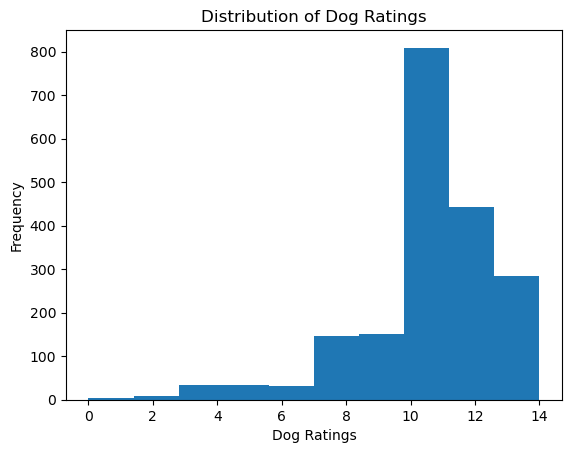

In [62]:
# plot the distribution of the numerator rating using histogram
plt.hist(data = df_archive, x = 'rating_numerator')
plt.title('Distribution of Dog Ratings');
plt.xlabel('Dog Ratings')
plt.ylabel('Frequency');

The dog ratings has a left-tailed distribution. WeRateDog gives out rates between 0 and 14 for the dogs. The rating with the highest frequency is around 11.

### Which dog breed is mostly tweeted about?

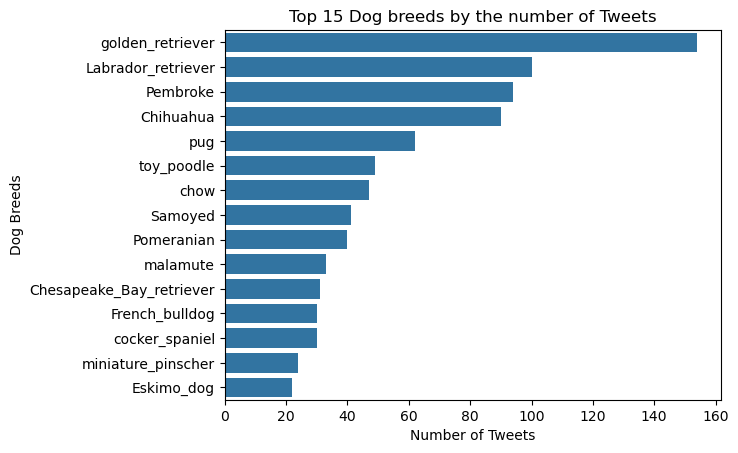

In [63]:
base_color = sns.color_palette()[0]
# set the plot order and eliminate the None value by excluding index 0
top_15_breeds = df_archive.dog_breed.value_counts().iloc[1:16].index

# plot the bar chart for the top 15 dog breeds by tweet counts
sns.countplot(data = df_archive, y = 'dog_breed', order = top_15_breeds, 
              color = base_color)
plt.title('Top 15 Dog breeds by the number of Tweets')
plt.ylabel('Dog Breeds')
plt.xlabel('Number of Tweets');

The dog breed mostly tweeted about by WeRateDog is the Golden Retriever followed by the Labrador Retriever.

### Which dog breed has the highest favourite counts

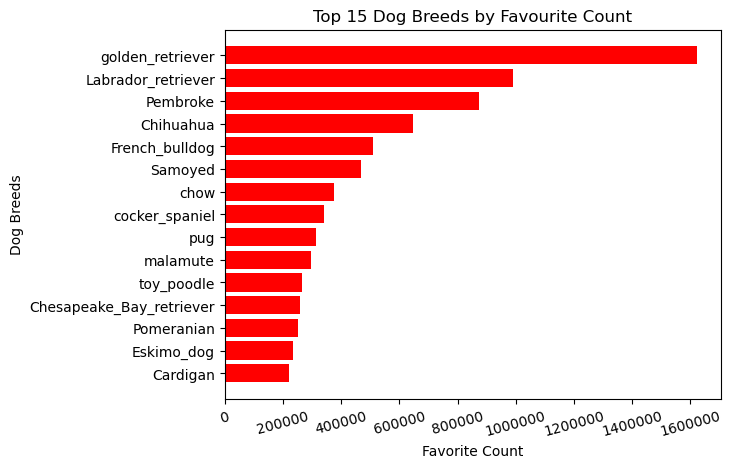

In [64]:
# summarize the favorite count by dog breed and sort descending
breed_count = df_archive.groupby('dog_breed')['favorite_count'].sum().sort_values(ascending=False)

# plot the bar chart for the top 15 dog breeds by favourite count
plt.barh(breed_count.iloc[1:16].index.values, breed_count.iloc[1:16], color= 'r')
plt.gca().invert_yaxis()
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation = 15)
plt.title('Top 15 Dog Breeds by Favourite Count')
plt.ylabel('Dog Breeds')
plt.xlabel('Favorite Count');

The top dog breed by favourite count is the Golden Retriever followed by the Labrador Retriever.

### Does WeRateDog numerator ratings influence the favourite count?

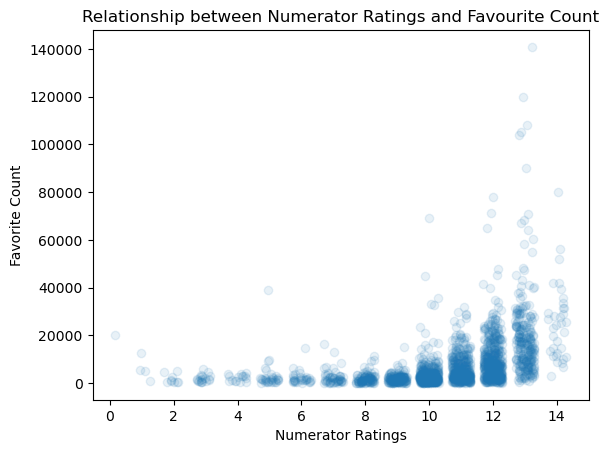

In [65]:
# plot the relationship between numerator ratings and favourite count
sns.regplot(data = df_archive, x = 'rating_numerator', y = 'favorite_count', 
            fit_reg = False, x_jitter=0.3, scatter_kws={'alpha':1/10})
plt.title('Relationship between Numerator Ratings and Favourite Count')
plt.xlabel('Numerator Ratings')
plt.ylabel('Favorite Count');

Some high ratings have more favorite counts. So there seems to be a positive relationship between numerator ratings and favourite count. As the numerator rating increases, the favorite count also increases.

### Is there any relationship between favourite count and retweet count?

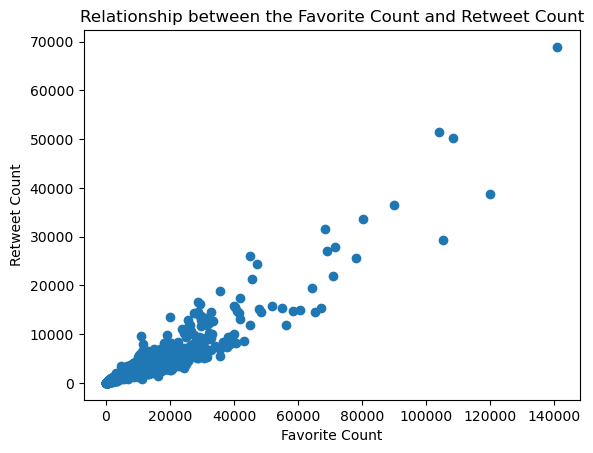

In [66]:
# plot the relationship between numerator ratings and favourite count
plt.scatter(data = df_archive, x = 'favorite_count', y = 'retweet_count')
plt.title('Relationship between the Favorite Count and Retweet Count')
plt.xlabel('Favorite Count')
plt.ylabel('Retweet Count');

There is a strong positive correlation between favorite count and retweet count as expected. As the favorite count increases, the retweet count also increases.

## Conclusion

I gathered data from three different sources: 
- The WeRateDogs Twitter archive - A file provided by Udacity
- Images prediction files - A file downloaded programmatically from Udacity server
- Additional data from the Twitter API - gathering through Twitter API

I assessed, identified and cleaned the following quality and tidiness issues:
#### Quality Issues

#### `Archived` table

- Erroneous data type for timestamp and Tweet id
- Drop extraneous columns (Retweets and reply columns) and rows. We are only interested in the original tweets.
- Source links should be shortened
- Rating denominator has values greater than 10
- Rating numerator has large values like 960 and 1776
- Name column contains some wrong names like a, an, the, just, very, quite etc
- Remove rows without dog images
- Drop null values

#### `Twitter API` table
- Tweet id should be a string and not integer
- Missing data. The data has 33 rows less than the twitter archived

#### `Images` table
- Tweet id should be a string and not integer
- Missing data. The data has 281 rows less than the twitter archived

#### Tidiness Issues

- Dog stages in the archived table should be in one column and not four columns
- Multiple columns in the Images table for dog breeds and confidence predictions
- Twitter API and Images tables should be part of archived table.

And I gathered the following insights:
### Insights
- The numerical rating distribution is left-tailed and the highest rating is around 11.
- Golden Retriever is the dog breed mostly tweeted about by WeRateDog and it has the highest favorite count.
- WeRateDog rating seems to influence the favorite count for dog breeds and
- Favorite count has a strong positive correlation with the retweet count.